Code from [scale embedding-decoder](https://git.scc.kit.edu/scale/research/embedding-decoder) with slight changes

In [1]:
import os
import random

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

using project root as working dir


In [2]:
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
import seaborn as sns
import random

from src.map import Map
from src.disc import gen_disc_graph, gen_disc_edge

In [3]:
args = Map(
    batch_size = 64,
    epochs = 50,
    random_seed = None,
    graph_size = 1000,
    graph_average_degree = 10,
    rg_radius = 0.05,
    layers = 10,
    layer_size = 16,
    train_size = 0.7,
    wandb = False,
    ds_padded = False,
)

### Generate Graph

Generates the unit disc graph.

In [4]:
if args.wandb:
    wandb.login()
    wandb.init(project="embedding-eval-framework", entity="hydrofin")
    wandb.run

In [5]:
nx_graph, node_pos, _ = gen_disc_graph(args.graph_size, args.graph_average_degree, args.rg_radius)
largest_component = max(nx.connected_components(nx_graph), key=len)

Nodes: 1000
Edges: 4909
Average Degree: 9.818
Largest Component Size: 1000


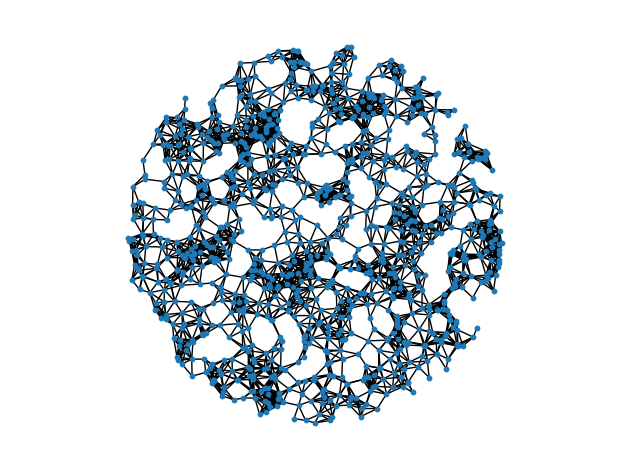

In [6]:
print(f'Nodes: {nx_graph.number_of_nodes()}')
print(f'Edges: {nx_graph.number_of_edges()}')
print(f'Average Degree: {2.0 * nx_graph.number_of_edges() / nx_graph.number_of_nodes()}')
print(f'Largest Component Size: {len(largest_component)}')

fig = plt.figure()
ax = fig.add_subplot()

nx.draw_networkx(nx_graph, node_pos, ax=ax, node_size=10, with_labels=False, labels={})
plt.axis('off')
fig.set_facecolor('w')

plt.axis('equal')
fig.tight_layout()
plt.show()

if args.wandb:
    wandb.log({
        "generated_graph": wandb.Image(plt)
    })

### Train Decoder

Trains a decoder from the graph.

In [7]:
graph_nodes = nx.nodes(nx_graph)

# all combinations of x and y (with x > y)
ds_edge_pairs = [ [ei0, ei1] for ei0 in tqdm(range(nx_graph.number_of_nodes()), desc="generating edge pairs") for ei1 in range(ei0 + 1, nx_graph.number_of_nodes()) ]
ds_edges_pos = [ [graph_nodes[ei0]['pos'][0], graph_nodes[ei0]['pos'][1], graph_nodes[ei1]['pos'][0], graph_nodes[ei1]['pos'][1]] for [ei0, ei1] in tqdm(ds_edge_pairs, desc="mapping edge positions") ]
ds_edges_label = [ 1 if nx_graph.has_edge(ei0, ei1) else 0 for [ei0, ei1] in tqdm(ds_edge_pairs, desc="creating labels for edges") ]

creating labels for edges: 100%|██████████| 499500/499500 [00:00<00:00, 2758752.85it/s]


In [8]:
# pad data
if args.ds_padded:
    label_diff = ds_edges_label.count(0) - ds_edges_label.count(1)
    label1_is = [i for i, el in tqdm(enumerate(ds_edges_label), desc="generating duplicates") if el == 1]
    label1_is_sample = random.sample(label1_is, label_diff, counts=([label_diff] * len(label1_is)))
    pad_ds_edges_pos   = ds_edges_pos   + [ds_edges_pos[i] for i in tqdm(label1_is_sample, desc="adding duplicates for positions")]
    pad_ds_edges_label = ds_edges_label + [ds_edges_label[i] for i in tqdm(label1_is_sample, desc="adding duplicates for labels")]
else:
    pad_ds_edges_pos   = ds_edges_pos
    pad_ds_edges_label = ds_edges_label

In [9]:
# tensorflow

# generate dataset from graph from previous
full_dataset = tf.data.Dataset.from_tensor_slices((pad_ds_edges_pos, pad_ds_edges_label)).batch(args.batch_size)

## preprocess with data padding (duplicate edges in buckets so that all buckets have same amount of edges)

# split dataset
full_dataset = full_dataset.shuffle(nx_graph.number_of_nodes())
train_dataset = full_dataset.take(int(args.train_size * nx_graph.number_of_nodes()))
test_dataset = full_dataset.take(int((1 - args.train_size) * nx_graph.number_of_nodes()))

# build model(s)
model_array = [
    tf.keras.layers.InputLayer(input_shape=4)] # possible TODO get input shape dynamically

for i in range(args.layers):
    model_array.append(tf.keras.layers.Dense(args.layer_size, activation='relu')) # make size depending on graph dimensionality? Or would that against the idea?

model_array.append(tf.keras.layers.Flatten())
model_array.append(tf.keras.layers.Dense(1, activation='sigmoid'))

dense_model = tf.keras.Sequential(model_array)

dense_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(), # TODO try other loss function
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(thresholds=0),
        tf.keras.metrics.AUC(
            curve="PR"
        ),
        #tfma.metrics.AUCPrecisionRecall()
    ]
)

# train
callbacks = []
if args.wandb:
    callbacks.append(WandbCallback())
train_history = dense_model.fit(train_dataset, epochs=args.epochs, callbacks=callbacks)

# evaluate
test_loss, test_acc, e1, e2 = dense_model.evaluate(test_dataset, verbose=0)
dense_model.summary()

Epoch 1/50
700/700 [==============================] - 2s 1ms/step - loss: 0.0865 - accuracy: 0.9901 - recall: 1.0000 - auc: 0.0138
Epoch 2/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0289 - accuracy: 0.9901 - recall: 1.0000 - auc: 0.3213
Epoch 3/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0171 - accuracy: 0.9926 - recall: 1.0000 - auc: 0.5740
Epoch 4/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0154 - accuracy: 0.9939 - recall: 1.0000 - auc: 0.6069
Epoch 5/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0132 - accuracy: 0.9944 - recall: 1.0000 - auc: 0.6949
Epoch 6/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0118 - accuracy: 0.9947 - recall: 1.0000 - auc: 0.7844
Epoch 7/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0120 - accuracy: 0.9950 - recall: 1.0000 - auc: 0.7429
Epoch 8/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0116 - 

In [10]:
predictions = dense_model.predict(ds_edges_pos) # cartesian
edge_prediction = [pred[0] for pred in predictions]

15610/15610 [==============================] - 10s 653us/step


In [11]:
pred_graph = nx.create_empty_copy(nx_graph, with_data=True)
edges = [ pair for pair, prediction in zip(ds_edge_pairs, edge_prediction) if (prediction >= 0.1) ] # and (pair[0] != pair[1])
pred_graph.add_edges_from(edges)

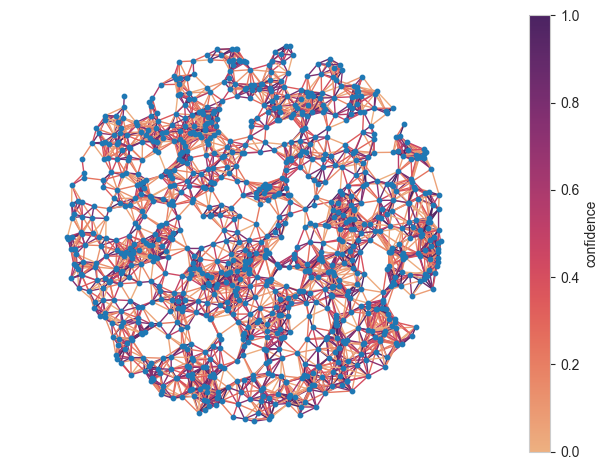

In [12]:
c1='#1f77b4' #blue
c2='green' #green

colors = np.array([ pred for pred in edge_prediction if (pred >= 0.1)])
colormap = sns.color_palette("flare", as_cmap=True)
options = {
    #"node_color": "#A0CBE2",
    "edge_color": colors,
    "node_size": 10,
    "edge_cmap": colormap,
    "with_labels": False,
}

fig = plt.figure()
ax = fig.add_subplot()
fig.colorbar(mpl.cm.ScalarMappable(cmap=colormap), ax=ax, label="confidence")

nx.draw_networkx(pred_graph, node_pos, ax=ax, **options, label="reconstructed graph")

# Setting it to how it was looking before.
plt.axis('off')
plt.axis('equal')
fig.set_facecolor('w')

#plt.legend()

fig.tight_layout()
plt.show()

if args.wandb:
    wandb.log({
        "predicted_graph": wandb.Image(plt)
    })

In [13]:
if args.wandb:
    wandb.finish()

### Additional Plots

Additional plots of information about the decoder.

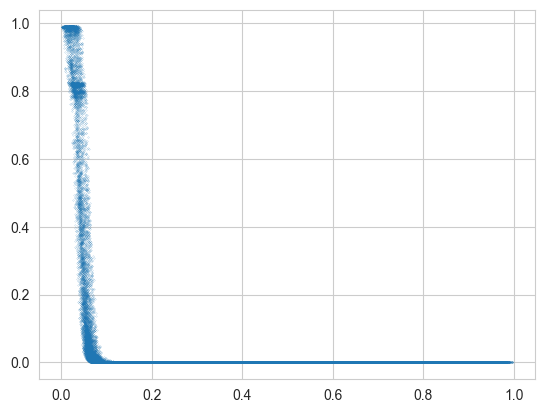

In [14]:
distances = [math.dist([px, py], [qx, qy]) for [px, py, qx, qy] in ds_edges_pos]
fig, ax = plt.subplots()
ax.scatter(distances, edge_prediction, s=0.01)
plt.show()
## smaller points
## also with lines between (has to be sorted first)
## plot into #of-edges per distance (see how much data/information the nn gets per distance)
## more points (for more information around threshold distance)

## get threshold back with ml/wsk-theory

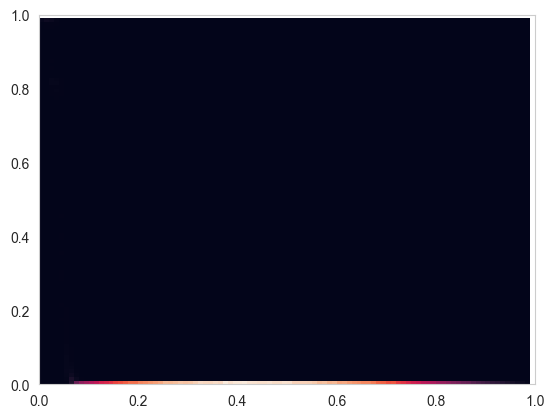

In [15]:
fig, ax = plt.subplots()
ax.hist2d([dist for dist in distances], edge_prediction, bins=(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01)))
ax.set(xlim=(0, 1), ylim=(0, 1))
plt.show()

In [16]:
test_distances = np.arange(0, 1, 0.01)
dist_dup = 10
test_edges = [(d, gen_disc_edge(d)) for d in np.tile(test_distances, dist_dup)]
test_edges

[(0.0,
  [0.3591569492848946,
   0.17141494338575602,
   0.3591569492848946,
   0.17141494338575602]),
 (0.01,
  [0.4556728247534996,
   0.9754318845311147,
   0.4640852166293318,
   0.9808385159155751]),
 (0.02,
  [0.4702551047649982,
   0.8590280781143012,
   0.4886602118508347,
   0.8668544459282294]),
 (0.03,
  [0.7790288772469339,
   0.8152559378714804,
   0.7992248522074623,
   0.8374397742257658]),
 (0.04,
  [0.3113723190299158,
   0.875024716156361,
   0.3262856426753558,
   0.9121406531355936]),
 (0.05,
  [0.5962919288261004,
   0.8102918311560123,
   0.6270519067782396,
   0.8497104023678651]),
 (0.06,
  [0.35086547414989333,
   0.05763337895870846,
   0.35121584397684863,
   0.11763235595819037]),
 (0.07,
  [0.23382110475615359,
   0.13174842566188505,
   0.29422817364626186,
   0.16711770651555408]),
 (0.08,
  [0.38646131792106,
   0.38807114616156047,
   0.4358021536248989,
   0.451043218797347]),
 (0.09,
  [0.6579981373895161,
   0.6560497809366025,
   0.7243797338899771,

In [17]:
test_predictions = dense_model.predict([edge for (_, edge) in test_edges]) # cartesian
test_edge_prediction = [pred[0] for pred in test_predictions]
len(test_edges), len(test_edge_prediction)

32/32 [==============================] - 0s 645us/step


(1000, 1000)

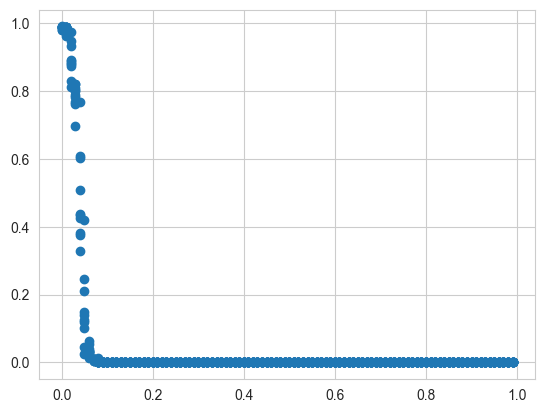

In [18]:
fig, ax = plt.subplots()
ax.scatter([d for (d, _) in test_edges], test_edge_prediction)
plt.show()

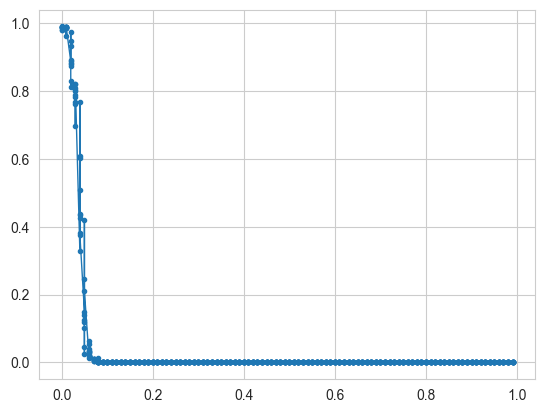

In [19]:
sorted_dist, sorted_pred = zip(*sorted(zip([d for (d, _) in test_edges], test_edge_prediction), key = lambda x: x[0]))
fig, ax = plt.subplots()
ax.plot(sorted_dist, sorted_pred, marker='o', linewidth=1, markersize=3)
plt.show()

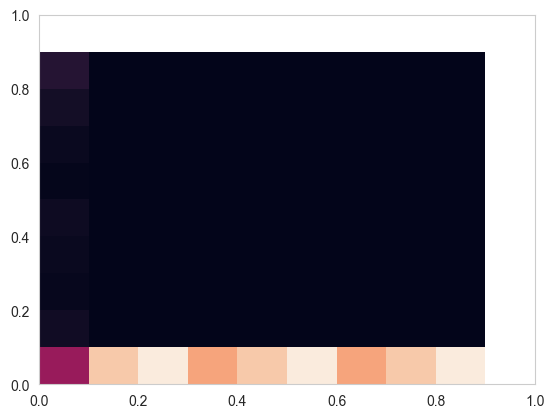

In [20]:
fig, ax = plt.subplots()
ax.hist2d([d for (d, _) in test_edges], test_edge_prediction, bins=(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1)))
ax.set(xlim=(0, 1), ylim=(0, 1))

plt.show()